
這個是 [Langgraph - SQL Agent的教學中文化](https://langchain-ai.github.io/langgraph/tutorials/sql-agent/)，可根據你自己的需求修改。

後面的評估方面使用官方的案例跑是不能動的，所以相關的部分我就先刪掉了，貌似那邊還是有點bug，不過這個範例可以很直觀地看到大概RAG 是怎麼運作的。

貌似使用langsmith track 運作的過程還是有點bug的
# 一個與 SQL 資料庫交互的 Agent

在本範例中，我們將逐步介紹如何構建一個能夠回答有關 SQL 資料庫問題的 Agent。

從高層次來看，這個 Agent 將會：
1. 從資料庫中獲取可用的表格
2. 判斷哪些表格與問題相關
3. 獲取相關表格的 DDL（數據定義語言）
4. 根據問題和從 DDL 獲取的信息生成查詢
5. 使用大型語言模型 (LLM) 再次檢查查詢是否有常見錯誤
6. 執行查詢並返回結果
7. 根據結果制定回覆
8. 根據結果制定回覆

端到端的流程如下所示:

![](https://github.com/langchain-ai/langgraph/blob/main/examples/tutorials/sql-agent-diagram.png?raw=1)

## 設定環境

我們將設定 OpenAI 的環境參數，以及增加 [LangSmith](https://smith.langchain.com) 的追蹤設定。


In [1]:
import os

os.environ["OPENAI_API_KEY"] = "請換成你的key"
os.environ["LANGSMITH_API_KEY"] = "請換成你的key"
os.environ["LANGCHAIN_TRACING_V2"] = "true"
!export LANGCHAIN_API_KEY= "請換成你的key"

In [2]:
os.environ["LANGCHAIN_PROJECT"] = "sql-agent"

## 配置數據庫

在本教程中，我們將創建一個 SQLite 數據庫。SQLite 是一個輕量級數據庫，易於設置和使用。我們將加載 `chinook` 數據庫，[這是一個呈現數字媒體商店的範例集資料庫。](https://www.sqlitetutorial.net/sqlite-sample-database/)

為了方便起見，我們已將數據庫（`Chinook.db`）託管在公開的 GCS 頁面上。


In [3]:
import requests

url = "https://storage.googleapis.com/benchmarks-artifacts/chinook/Chinook.db"

response = requests.get(url)

if response.status_code == 200:
    # Open a local file in binary write mode
    with open("Chinook.db", "wb") as file:
        # Write the content of the response (the file) to the local file
        file.write(response.content)
    print("File downloaded and saved as Chinook.db")
else:
    print(f"Failed to download the file. Status code: {response.status_code}")

File downloaded and saved as Chinook.db




我們將使用 `langchain_community` 套件中提供的便捷 SQL 數據庫包裝器來與數據庫交互。這個包裝器提供了一個簡化的接口，讓我們可以輕鬆地執行 SQL 查詢並獲取結果。此外，在本範例的後續部分，我們還將使用 `langchain_openai` 套件與 OpenAI API 的語言模型進行互動。


In [4]:
%%capture --no-stderr --no-display
!pip install langgraph langchain_community langchain_openai

In [5]:
from langchain_community.utilities import SQLDatabase

db = SQLDatabase.from_uri("sqlite:///Chinook.db")
print(db.dialect)
print(db.get_usable_table_names())
db.run("SELECT * FROM Artist LIMIT 10;")

sqlite
['Album', 'Artist', 'Customer', 'Employee', 'Genre', 'Invoice', 'InvoiceLine', 'MediaType', 'Playlist', 'PlaylistTrack', 'Track']


"[(1, 'AC/DC'), (2, 'Accept'), (3, 'Aerosmith'), (4, 'Alanis Morissette'), (5, 'Alice In Chains'), (6, 'Antônio Carlos Jobim'), (7, 'Apocalyptica'), (8, 'Audioslave'), (9, 'BackBeat'), (10, 'Billy Cobham')]"



## 工具函數

我們將定義一些工具函數來協助我們實現agent。具體來說，我們會將一個 `ToolNode` 包裝起來，加入一個備援機制來處理錯誤，並將錯誤訊息呈現給agent。


In [6]:
from typing import Any

from langchain_core.messages import ToolMessage
from langchain_core.runnables import RunnableLambda, RunnableWithFallbacks
from langgraph.prebuilt import ToolNode


def create_tool_node_with_fallback(tools: list) -> RunnableWithFallbacks[Any, dict]:
    """
    Create a ToolNode with a fallback to handle errors and surface them to the agent.
    """
    return ToolNode(tools).with_fallbacks(
        [RunnableLambda(handle_tool_error)], exception_key="error"
    )


def handle_tool_error(state) -> dict:
    error = state.get("error")
    tool_calls = state["messages"][-1].tool_calls
    return {
        "messages": [
            ToolMessage(
                content=f"Error: {repr(error)}\n please fix your mistakes.",
                tool_call_id=tc["id"],
            )
            for tc in tool_calls
        ]
    }



## 為agent定義工具

我們將定義幾個工具，讓agent用來與數據庫進行交互。

1. `list_tables_tool`：從數據庫中獲取可用的表格列表
2. `get_schema_tool`：獲取表格的 DDL（數據定義語言）信息
3. `db_query_tool`：執行查詢並獲取結果，或者在查詢失敗時返回錯誤訊息

對於前兩個工具，我們將從 `langchain_community` 套件中同樣提供的 `SQLDatabaseToolkit` 中獲取它們。


In [7]:
from langchain_community.agent_toolkits import SQLDatabaseToolkit
from langchain_openai import ChatOpenAI

toolkit = SQLDatabaseToolkit(db=db, llm=ChatOpenAI(model="gpt-4o"))
tools = toolkit.get_tools()

list_tables_tool = next(tool for tool in tools if tool.name == "sql_db_list_tables")
get_schema_tool = next(tool for tool in tools if tool.name == "sql_db_schema")

print(list_tables_tool.invoke(""))

print(get_schema_tool.invoke("Artist"))

Album, Artist, Customer, Employee, Genre, Invoice, InvoiceLine, MediaType, Playlist, PlaylistTrack, Track

CREATE TABLE "Artist" (
	"ArtistId" INTEGER NOT NULL, 
	"Name" NVARCHAR(120), 
	PRIMARY KEY ("ArtistId")
)

/*
3 rows from Artist table:
ArtistId	Name
1	AC/DC
2	Accept
3	Aerosmith
*/



第三個工具將由我們手動定義。對於 `db_query_tool`，我們將對數據庫執行查詢並返回結果。


In [8]:
from langchain_core.tools import tool


@tool
def db_query_tool(query: str) -> str:
    """
    Execute a SQL query against the database and get back the result.
    If the query is not correct, an error message will be returned.
    If an error is returned, rewrite the query, check the query, and try again.
    """
    result = db.run_no_throw(query)
    if not result:
        return "Error: Query failed. Please rewrite your query and try again."
    return result


print(db_query_tool.invoke("SELECT * FROM Artist LIMIT 10;"))

[(1, 'AC/DC'), (2, 'Accept'), (3, 'Aerosmith'), (4, 'Alanis Morissette'), (5, 'Alice In Chains'), (6, 'Antônio Carlos Jobim'), (7, 'Apocalyptica'), (8, 'Audioslave'), (9, 'BackBeat'), (10, 'Billy Cobham')]




雖然嚴格來說這並不算是一個工具，但我們將提示一個大型語言模型 (LLM) 來檢查查詢中常見的錯誤，並在之後將其作為一個節點添加到工作流程中。


In [9]:
from langchain_core.prompts import ChatPromptTemplate

query_check_system = """You are a SQL expert with a strong attention to detail.
Double check the SQLite query for common mistakes, including:
- Using NOT IN with NULL values
- Using UNION when UNION ALL should have been used
- Using BETWEEN for exclusive ranges
- Data type mismatch in predicates
- Properly quoting identifiers
- Using the correct number of arguments for functions
- Casting to the correct data type
- Using the proper columns for joins

If there are any of the above mistakes, rewrite the query. If there are no mistakes, just reproduce the original query.

You will call the appropriate tool to execute the query after running this check."""

query_check_prompt = ChatPromptTemplate.from_messages(
    [("system", query_check_system), ("placeholder", "{messages}")]
)
query_check = query_check_prompt | ChatOpenAI(model="gpt-4o", temperature=0).bind_tools(
    [db_query_tool], tool_choice="required"
)

query_check.invoke({"messages": [("user", "SELECT * FROM Artist LIMIT 10;")]})

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_Pngfm02YTGWTAhUXuGvlYmBc', 'function': {'arguments': '{"query":"SELECT * FROM Artist LIMIT 10;"}', 'name': 'db_query_tool'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 20, 'prompt_tokens': 221, 'total_tokens': 241}, 'model_name': 'gpt-4o-2024-05-13', 'system_fingerprint': 'fp_3aa7262c27', 'finish_reason': 'stop', 'logprobs': None}, id='run-e76988a5-2cab-4799-a530-39422e1bac2d-0', tool_calls=[{'name': 'db_query_tool', 'args': {'query': 'SELECT * FROM Artist LIMIT 10;'}, 'id': 'call_Pngfm02YTGWTAhUXuGvlYmBc', 'type': 'tool_call'}], usage_metadata={'input_tokens': 221, 'output_tokens': 20, 'total_tokens': 241})


## 定義工作流程

接著，我們將為 agent 定義工作流程。agent 會首先強制調用 `list_tables_tool` 來從數據庫中獲取可用的表格列表，然後按照教程開頭提到的步驟執行。


In [10]:
from typing import Annotated, Literal

from langchain_core.messages import AIMessage
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_openai import ChatOpenAI
from typing_extensions import TypedDict

from langgraph.graph import END, StateGraph, START
from langgraph.graph.message import AnyMessage, add_messages


# Define the state for the agent
class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]


# Define a new graph
workflow = StateGraph(State)


# Add a node for the first tool call
def first_tool_call(state: State) -> dict[str, list[AIMessage]]:
    return {
        "messages": [
            AIMessage(
                content="",
                tool_calls=[
                    {
                        "name": "sql_db_list_tables",
                        "args": {},
                        "id": "tool_abcd123",
                    }
                ],
            )
        ]
    }


def model_check_query(state: State) -> dict[str, list[AIMessage]]:
    """
    Use this tool to double-check if your query is correct before executing it.
    """
    return {"messages": [query_check.invoke({"messages": [state["messages"][-1]]})]}


workflow.add_node("first_tool_call", first_tool_call)

# Add nodes for the first two tools
workflow.add_node(
    "list_tables_tool", create_tool_node_with_fallback([list_tables_tool])
)
workflow.add_node("get_schema_tool", create_tool_node_with_fallback([get_schema_tool]))

# Add a node for a model to choose the relevant tables based on the question and available tables
model_get_schema = ChatOpenAI(model="gpt-4o", temperature=0).bind_tools(
    [get_schema_tool]
)
workflow.add_node(
    "model_get_schema",
    lambda state: {
        "messages": [model_get_schema.invoke(state["messages"])],
    },
)


# Describe a tool to represent the end state
class SubmitFinalAnswer(BaseModel):
    """Submit the final answer to the user based on the query results."""

    final_answer: str = Field(..., description="The final answer to the user")


# Add a node for a model to generate a query based on the question and schema
query_gen_system = """You are a SQL expert with a strong attention to detail.

Given an input question, output a syntactically correct SQLite query to run, then look at the results of the query and return the answer.

DO NOT call any tool besides SubmitFinalAnswer to submit the final answer.

When generating the query:

Output the SQL query that answers the input question without a tool call.

Unless the user specifies a specific number of examples they wish to obtain, always limit your query to at most 5 results.
You can order the results by a relevant column to return the most interesting examples in the database.
Never query for all the columns from a specific table, only ask for the relevant columns given the question.

If you get an error while executing a query, rewrite the query and try again.

If you get an empty result set, you should try to rewrite the query to get a non-empty result set.
NEVER make stuff up if you don't have enough information to answer the query... just say you don't have enough information.

If you have enough information to answer the input question, simply invoke the appropriate tool to submit the final answer to the user.

DO NOT make any DML statements (INSERT, UPDATE, DELETE, DROP etc.) to the database."""
query_gen_prompt = ChatPromptTemplate.from_messages(
    [("system", query_gen_system), ("placeholder", "{messages}")]
)
query_gen = query_gen_prompt | ChatOpenAI(model="gpt-4o", temperature=0).bind_tools(
    [SubmitFinalAnswer]
)


def query_gen_node(state: State):
    message = query_gen.invoke(state)

    # Sometimes, the LLM will hallucinate and call the wrong tool. We need to catch this and return an error message.
    tool_messages = []
    if message.tool_calls:
        for tc in message.tool_calls:
            if tc["name"] != "SubmitFinalAnswer":
                tool_messages.append(
                    ToolMessage(
                        content=f"Error: The wrong tool was called: {tc['name']}. Please fix your mistakes. Remember to only call SubmitFinalAnswer to submit the final answer. Generated queries should be outputted WITHOUT a tool call.",
                        tool_call_id=tc["id"],
                    )
                )
    else:
        tool_messages = []
    return {"messages": [message] + tool_messages}


workflow.add_node("query_gen", query_gen_node)

# Add a node for the model to check the query before executing it
workflow.add_node("correct_query", model_check_query)

# Add node for executing the query
workflow.add_node("execute_query", create_tool_node_with_fallback([db_query_tool]))


# Define a conditional edge to decide whether to continue or end the workflow
def should_continue(state: State) -> Literal[END, "correct_query", "query_gen"]:
    messages = state["messages"]
    last_message = messages[-1]
    # If there is a tool call, then we finish
    if getattr(last_message, "tool_calls", None):
        return END
    if last_message.content.startswith("Error:"):
        return "query_gen"
    else:
        return "correct_query"


# Specify the edges between the nodes
workflow.add_edge(START, "first_tool_call")
workflow.add_edge("first_tool_call", "list_tables_tool")
workflow.add_edge("list_tables_tool", "model_get_schema")
workflow.add_edge("model_get_schema", "get_schema_tool")
workflow.add_edge("get_schema_tool", "query_gen")
workflow.add_conditional_edges(
    "query_gen",
    should_continue,
)
workflow.add_edge("correct_query", "execute_query")
workflow.add_edge("execute_query", "query_gen")

# Compile the workflow into a runnable
app = workflow.compile()

## 流程圖表化

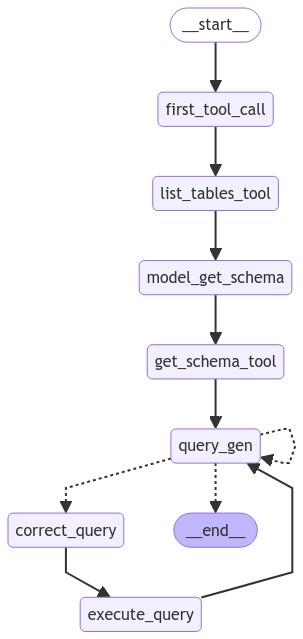

In [11]:
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

## 運行 Agent

In [12]:
import json

messages = app.invoke(
    {"messages": [("user", "Which sales agent made the most in sales in 2009?")]}
)
json_str = messages["messages"][-1].additional_kwargs["tool_calls"][0]["function"][
    "arguments"
]
json.loads(json_str)["final_answer"]

'The sales agent who made the most in sales in 2009 is Steve Johnson with a total of $164.34.'

In [13]:
for event in app.stream(
    {"messages": [("user", "Which sales agent made the most in sales in 2009?")]}
):
    print(event)

{'first_tool_call': {'messages': [AIMessage(content='', tool_calls=[{'name': 'sql_db_list_tables', 'args': {}, 'id': 'tool_abcd123', 'type': 'tool_call'}])]}}
{'list_tables_tool': {'messages': [ToolMessage(content='Album, Artist, Customer, Employee, Genre, Invoice, InvoiceLine, MediaType, Playlist, PlaylistTrack, Track', name='sql_db_list_tables', tool_call_id='tool_abcd123')]}}
{'model_get_schema': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_kkvrsZdG2I4isi9Lpc6Xsghw', 'function': {'arguments': '{"table_names":"Employee, Invoice"}', 'name': 'sql_db_schema'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 18, 'prompt_tokens': 177, 'total_tokens': 195}, 'model_name': 'gpt-4o-2024-05-13', 'system_fingerprint': 'fp_c9aa9c0491', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-9c84b9ea-46c2-40ba-9c8b-98d420bb85c5-0', tool_calls=[{'name': 'sql_db_schema', 'args': {'table_names': 'Employee, Invoic


## 評估

評估
現在，我們可以對這個agent進行評估了！我們之前已經定義了[簡單的 SQL agent](https://github.com/langchain-ai/langsmith-cookbook/blob/main/testing-examples/agent-evals-with-langgraph/langgraph_sql_agent_eval.ipynb)作為 LangSmith 評估 Cookbook 的一部分，並對關於我們數據庫的 5 個問題的回答進行了評估。我們可以在相同的數據集上將這個 agent 與我們之前的agent進行比較。[agent 評估](https://docs.smith.langchain.com/concepts/evaluation#agents)可以關注三個方面：

響應（Response）：輸入是一個提示和一個工具列表，輸出是 Agent 的響應。
單個工具（Single tool）：與之前一樣，輸入是一個提示和一個工具列表，輸出是工具調用。
軌跡（Trajectory）：與之前一樣，輸入是一個提示和一個工具列表，輸出是工具調用列表。
響應
我們將評估我們代理的端到端響應相對於參考答案的情況。讓我們在相同的數據集上運行響應評估。

* `響應（Response）`: 輸入是一個提示和一個工具列表，輸出是 Agent 的響應。
* `單個工具（Single tool）`: 與之前一樣，輸入是一個提示和一個工具列表，輸出是工具調用。
* `軌跡（Trajectory）`: 與之前一樣，輸入是一個提示和一個工具列表，輸出是工具調用列表。

![Screenshot 2024-06-13 at 2.13.30 PM.png](https://github.com/markl-a/LLM-agent-Demo/raw/main/1.LangchainDemos/sql_agent.png)

### 響應評估


我們將評估我們代理的端到端響應，並將其與參考答案進行比較。現在，讓我們[在相同的數據集](https://smith.langchain.com/public/20808486-67c3-4e30-920b-6d49d6f2b6b8/d)上運行[響應評估](https://docs.smith.langchain.com/concepts/evaluation#evaluating-an-agents-final-response)。

In [14]:
import json


def predict_sql_agent_answer(example: dict):
    """Use this for answer evaluation"""
    msg = {"messages": ("user", example["input"])}
    messages = app.invoke(msg)
    json_str = messages["messages"][-1].additional_kwargs["tool_calls"][0]["function"][
        "arguments"
    ]
    response = json.loads(json_str)["final_answer"]
    return {"response": response}

In [15]:
from langchain import hub
from langchain_openai import ChatOpenAI

# Grade prompt
grade_prompt_answer_accuracy = prompt = hub.pull("langchain-ai/rag-answer-vs-reference")


def answer_evaluator(run, example) -> dict:
    """
    A simple evaluator for RAG answer accuracy
    """

    # Get question, ground truth answer, chain
    input_question = example.inputs["input"]
    reference = example.outputs["output"]
    prediction = run.outputs["response"]

    # LLM grader
    llm = ChatOpenAI(model="gpt-4-turbo", temperature=0)

    # Structured prompt
    answer_grader = grade_prompt_answer_accuracy | llm

    # Run evaluator
    score = answer_grader.invoke(
        {
            "question": input_question,
            "correct_answer": reference,
            "student_answer": prediction,
        }
    )
    score = score["Score"]

    return {"key": "answer_v_reference_score", "score": score}

/usr/local/lib/python3.10/dist-packages/langchain_core/_api/beta_decorator.py:87: LangChainBetaWarning: The function `loads` is in beta. It is actively being worked on, so the API may change.
  warn_beta(


In [16]:
from langsmith.evaluation import evaluate

dataset_name = "SQL Agent Response"
experiment_results = evaluate(
    predict_sql_agent_answer,
    data=dataset_name,
    evaluators=[answer_evaluator],
    num_repetitions=3,
    experiment_prefix="sql-agent-multi-step-response-v-reference",
    metadata={"version": "Chinook, gpt-4o multi-step-agent"},
)

LangSmithNotFoundError: Dataset SQL Agent Response not found

摘要指標 (參見此處的[數據集](https://smith.langchain.com/public/20808486-67c3-4e30-920b-6d49d6f2b6b8/d)):

* 此處的`多步驟` agent 的表現優於先前定義的[基礎 SQL agent](https://github.com/langchain-ai/langsmith-cookbook/blob/main/testing-examples/agent-evals-with-langgraph/langgraph_sql_agent_eval.ipynb)。


### 軌跡評估

讓我們在相同的數據集上運行[軌跡評估](https://docs.smith.langchain.com/concepts/evaluation#evaluating-an-agents-trajectory)。



In [ ]:
# These are the tools that we expect the agent to use
expected_trajectory = [
    "sql_db_list_tables",  # first: list_tables_tool node
    "sql_db_schema",  # second: get_schema_tool node
    "db_query_tool",  # third: execute_query node
    "SubmitFinalAnswer",
]  # fourth: query_gen

In [ ]:
def predict_sql_agent_messages(example: dict):
    """Use this for answer evaluation"""
    msg = {"messages": ("user", example["input"])}
    messages = app.invoke(msg)
    return {"response": messages}

In [ ]:
from langsmith.schemas import Example, Run


def find_tool_calls(messages):
    """
    Find all tool calls in the messages returned
    """
    tool_calls = [
        tc["name"] for m in messages["messages"] for tc in getattr(m, "tool_calls", [])
    ]
    return tool_calls


def contains_all_tool_calls_in_order_exact_match(
    root_run: Run, example: Example
) -> dict:
    """
    Check if all expected tools are called in exact order and without any additional tool calls.
    """
    expected_trajectory = [
        "sql_db_list_tables",
        "sql_db_schema",
        "db_query_tool",
        "SubmitFinalAnswer",
    ]
    messages = root_run.outputs["response"]
    tool_calls = find_tool_calls(messages)

    # Print the tool calls for debugging
    print("Here are my tool calls:")
    print(tool_calls)

    # Check if the tool calls match the expected trajectory exactly
    if tool_calls == expected_trajectory:
        score = 1
    else:
        score = 0

    return {"score": int(score), "key": "multi_tool_call_in_exact_order"}


def contains_all_tool_calls_in_order(root_run: Run, example: Example) -> dict:
    """
    Check if all expected tools are called in order,
    but it allows for other tools to be called in between the expected ones.
    """
    messages = root_run.outputs["response"]
    tool_calls = find_tool_calls(messages)

    # Print the tool calls for debugging
    print("Here are my tool calls:")
    print(tool_calls)

    it = iter(tool_calls)
    if all(elem in it for elem in expected_trajectory):
        score = 1
    else:
        score = 0
    return {"score": int(score), "key": "multi_tool_call_in_order"}

In [ ]:
experiment_results = evaluate(
    predict_sql_agent_messages,
    data=dataset_name,
    evaluators=[
        contains_all_tool_calls_in_order,
        contains_all_tool_calls_in_order_exact_match,
    ],
    num_repetitions=3,
    experiment_prefix="sql-agent-multi-step-tool-calling-trajecory-in-order",
    metadata={"version": "Chinook, gpt-4o multi-step-agent"},
)

總體得分顯示，我們從未按照正確的順序調用工具：

![Screenshot 2024-06-13 at 2.46.34 PM.png](https://github.com/markl-a/LLM-agent-Demo/raw/main/1.LangchainDemos/sql_agent2.png)

查看日誌記錄，我們可以發現一些有趣的事情 -
```
['sql_db_list_tables', 'sql_db_schema', 'sql_db_query', 'db_query_tool', 'SubmitFinalAnswer']
```
在大部分的運行中，我們似乎在軌跡中注入了幻覺的工具調用 `sql_db_query`。

這就是為什麼 `multi_tool_call_in_exact_order` 失敗，但 `multi_tool_call_in_order` 仍然通過的原因。

我們將在未來的 Cookbook 中探索使用 LangGraph 來解決這個問題的方法！
